### Learning reaction types using a Random Forest classifier and different reaction fingerprints 

Goal: Test the influence of agents on the 50-class prediction

In [1]:
import _pickle as cPickle
import gzip
from collections import defaultdict
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import utilsFunctions
from pylab import rcParams

Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

Load the 50 reaction types and their names

In [3]:
dataDir = "../data/"


with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)
# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the FPs either as 2048 or 4096 bit version 

In [5]:
infile = gzip.open(dataDir+'reaction_FPs_training_test_set_patent_data.pkl.gz', 'rb')
#infile = gzip.open('dataDir+'reaction_FPs_4096bit_training_test_set_patent_data.pkl.gz', 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_woA,fp_wA1,fp_wA2,fp_wA3 = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_woA,fp_wA1,fp_wA2,fp_wA3])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


Split the FPs in training (20 %) and test data (80 %) per reaction type (200, 800)

In [7]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz=2048 # the FPs bit size for converting the FPs to a numpy array
#fpsz=4096
trainFps_wA1=[]
trainFps_wA2=[]
trainFps_wA3=[]
trainFps_woA=[]
trainActs=[]
testFps_wA1=[]
testFps_wA2=[]
testFps_wA3=[]
testFps_woA=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        trainFps_wA1 += [utilsFunctions.hashedFPToNP(fps[x][4],fpsz)]
        trainFps_wA2 += [utilsFunctions.hashedFPToNP(fps[x][5],fpsz)]
        trainFps_wA3 += [utilsFunctions.hashedFPToNP(fps[x][6],fpsz)]
        trainFps_woA += [utilsFunctions.hashedFPToNP(fps[x][3],fpsz)]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        testFps_wA1 += [utilsFunctions.hashedFPToNP(fps[x][4],fpsz)]
        testFps_wA2 += [utilsFunctions.hashedFPToNP(fps[x][5],fpsz)]
        testFps_wA3 += [utilsFunctions.hashedFPToNP(fps[x][6],fpsz)]
        testFps_woA += [utilsFunctions.hashedFPToNP(fps[x][3],fpsz)]
    testActs += [i]*nTest

building fp collection


Build the RF classifier with max tree depth of 25 (this gave the best performance)

In [8]:
print('training model')
rf_cls = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_cls_wA1 = rf_cls.fit(trainFps_wA1,trainActs)
result_rf_cls_wA2 = rf_cls.fit(trainFps_wA2,trainActs)
result_rf_cls_wA3 = rf_cls.fit(trainFps_wA3,trainActs)
result_rf_cls_woA = rf_cls.fit(trainFps_woA,trainActs)

training model


Evaluate the RF classifier using our test data

In [9]:
print('testing model')
preds_wA1 = result_rf_cls_wA1.predict(testFps_wA1)
newPreds_wA1=[rtypes[x] for x in preds_wA1]

preds_wA2 = result_rf_cls_wA2.predict(testFps_wA2)
newPreds_wA2=[rtypes[x] for x in preds_wA2]

preds_wA3 = result_rf_cls_wA3.predict(testFps_wA3)
newPreds_wA3=[rtypes[x] for x in preds_wA3]

preds_woA = result_rf_cls_woA.predict(testFps_woA)
newPreds_woA=[rtypes[x] for x in preds_woA]

newTestActs=[rtypes[x] for x in testActs]

cmat_wA1=metrics.confusion_matrix(newTestActs,newPreds_wA1)
cmat_wA2=metrics.confusion_matrix(newTestActs,newPreds_wA2)
cmat_wA3=metrics.confusion_matrix(newTestActs,newPreds_wA3)
cmat_woA=metrics.confusion_matrix(newTestActs,newPreds_woA)

colCounts_wA1 = sum(cmat_wA1,0)
rowCounts_wA1 = sum(cmat_wA1,1)
colCounts_wA2 = sum(cmat_wA2,0)
rowCounts_wA2 = sum(cmat_wA2,1)
colCounts_wA3 = sum(cmat_wA3,0)
rowCounts_wA3 = sum(cmat_wA3,1)
colCounts_woA = sum(cmat_woA,0)
rowCounts_woA = sum(cmat_woA,1)

print('%2s %23s %23s %23s %23s     %s'%("ID","wA_10_1","wA_10_-1","wA_1_1","woA","reaction class"))
sum_recall=[0]*4
sum_prec=[0]*4
for i,klass in enumerate(rtypes):

    recall_wA1 = 0
    if rowCounts_wA1[i] > 0:
        recall_wA1 = float(cmat_wA1[i,i])/rowCounts_wA1[i]
    sum_recall[0] += recall_wA1
    prec_wA1 = 0
    if colCounts_wA1[i] > 0:
        prec_wA1 = float(cmat_wA1[i,i])/colCounts_wA1[i]
    sum_prec[0] += prec_wA1
    f1_wA1 = 0
    if (recall_wA1 + prec_wA1) > 0:
        f1_wA1 = 2 * (recall_wA1 * prec_wA1) / (recall_wA1 + prec_wA1)
    
    recall_wA2 = 0
    if rowCounts_wA2[i] > 0:
        recall_wA2 = float(cmat_wA2[i,i])/rowCounts_wA2[i]
    sum_recall[1] += recall_wA2
    prec_wA2 = 0
    if colCounts_wA2[i] > 0:
        prec_wA2 = float(cmat_wA2[i,i])/colCounts_wA2[i]
    sum_prec[1] += prec_wA2
    f1_wA2 = 0
    if (recall_wA2 + prec_wA2) > 0:
        f1_wA2 = 2 * (recall_wA2 * prec_wA2) / (recall_wA2 + prec_wA2)
    
    recall_wA3 = 0
    if rowCounts_wA3[i] > 0:
        recall_wA3 = float(cmat_wA3[i,i])/rowCounts_wA3[i]
    sum_recall[2] += recall_wA3
    prec_wA3 = 0
    if colCounts_wA3[i] > 0:
        prec_wA3 = float(cmat_wA3[i,i])/colCounts_wA3[i]
    sum_prec[2] += prec_wA3
    f1_wA3 = 0
    if (recall_wA3 + prec_wA3) > 0:
        f1_wA3 = 2 * (recall_wA3 * prec_wA3) / (recall_wA3 + prec_wA3)
    
    recall_woA = 0
    if rowCounts_woA[i] > 0:
        recall_woA = float(cmat_woA[i,i])/rowCounts_woA[i]
    sum_recall[3] += recall_woA
    prec_woA = 0
    if colCounts_woA[i] > 0:
        prec_woA = float(cmat_woA[i,i])/colCounts_woA[i]
    sum_prec[3] += prec_woA
    f1_woA = 0
    if (recall_woA + prec_woA) > 0:
        f1_woA = 2 * (recall_woA * prec_woA) / (recall_woA + prec_woA)
    print('%2d % .4f % .4f % .4f % .4f % .4f % .4f % .4f % .4f % .4f % .4f % .4f % .4f % 9s %s'\
    %(i,recall_wA1,prec_wA1,f1_wA1,recall_wA2,prec_wA2,f1_wA2,recall_wA3,prec_wA3,f1_wA3,recall_woA,prec_woA,f1_woA,klass,names_rTypes[klass]))
mean_recall = [x/len(rtypes) for x in sum_recall]
mean_prec = [x/len(rtypes) for x in sum_prec]
mean_f1 = [2*(mean_recall[i]*mean_prec[i])/(mean_recall[i]+mean_prec[i]) for i in range(len(mean_recall)) if (mean_recall[i]+mean_prec[i])>0]
print("Mean:% 3.2f % 7.2f % 7.2f % 7.2f % 7.2f % 7.2f % 7.2f % 7.2f % 7.2f % 7.2f % 7.2f % 7.2f"\
%(mean_recall[0],mean_prec[0],mean_f1[0],mean_recall[1],mean_prec[1],mean_f1[1],mean_recall[2],mean_prec[2],mean_f1[2],mean_recall[3],mean_prec[3],mean_f1[3]))

testing model
ID                 wA_10_1                wA_10_-1                  wA_1_1                     woA     reaction class
 0  0.9883  0.9895  0.9889  0.9282  0.9294  0.9288  0.9883  0.9895  0.9889  0.9788  0.9800  0.9794     1.2.1 Aldehyde reductive amination
 1  0.7513  0.7520  0.7517  0.6580  0.6586  0.6583  0.7513  0.7520  0.7517  0.8686  0.8695  0.8690     1.2.4 Eschweiler-Clarke methylation
 2  0.9795  0.9808  0.9801  0.8958  0.8969  0.8963  0.9795  0.9808  0.9801  0.9800  0.9813  0.9807     1.2.5 Ketone reductive amination
 3  0.9593  0.9606  0.9599  0.9657  0.9673  0.9665  0.9593  0.9606  0.9599  0.9371  0.9383  0.9377     1.3.6 Bromo N-arylation
 4  0.9582  0.9594  0.9588  0.9773  0.9786  0.9780  0.9582  0.9594  0.9588  0.9387  0.9398  0.9393     1.3.7 Chloro N-arylation
 5  0.9737  0.9749  0.9743  0.9699  0.9711  0.9705  0.9737  0.9749  0.9743  0.9507  0.9519  0.9513     1.3.8 Fluoro N-arylation
 6  0.9456  0.9472  0.9464  0.9665  0.9685  0.9675  0.9456  0.9472  0.94

Draw the confusion matrices of our model

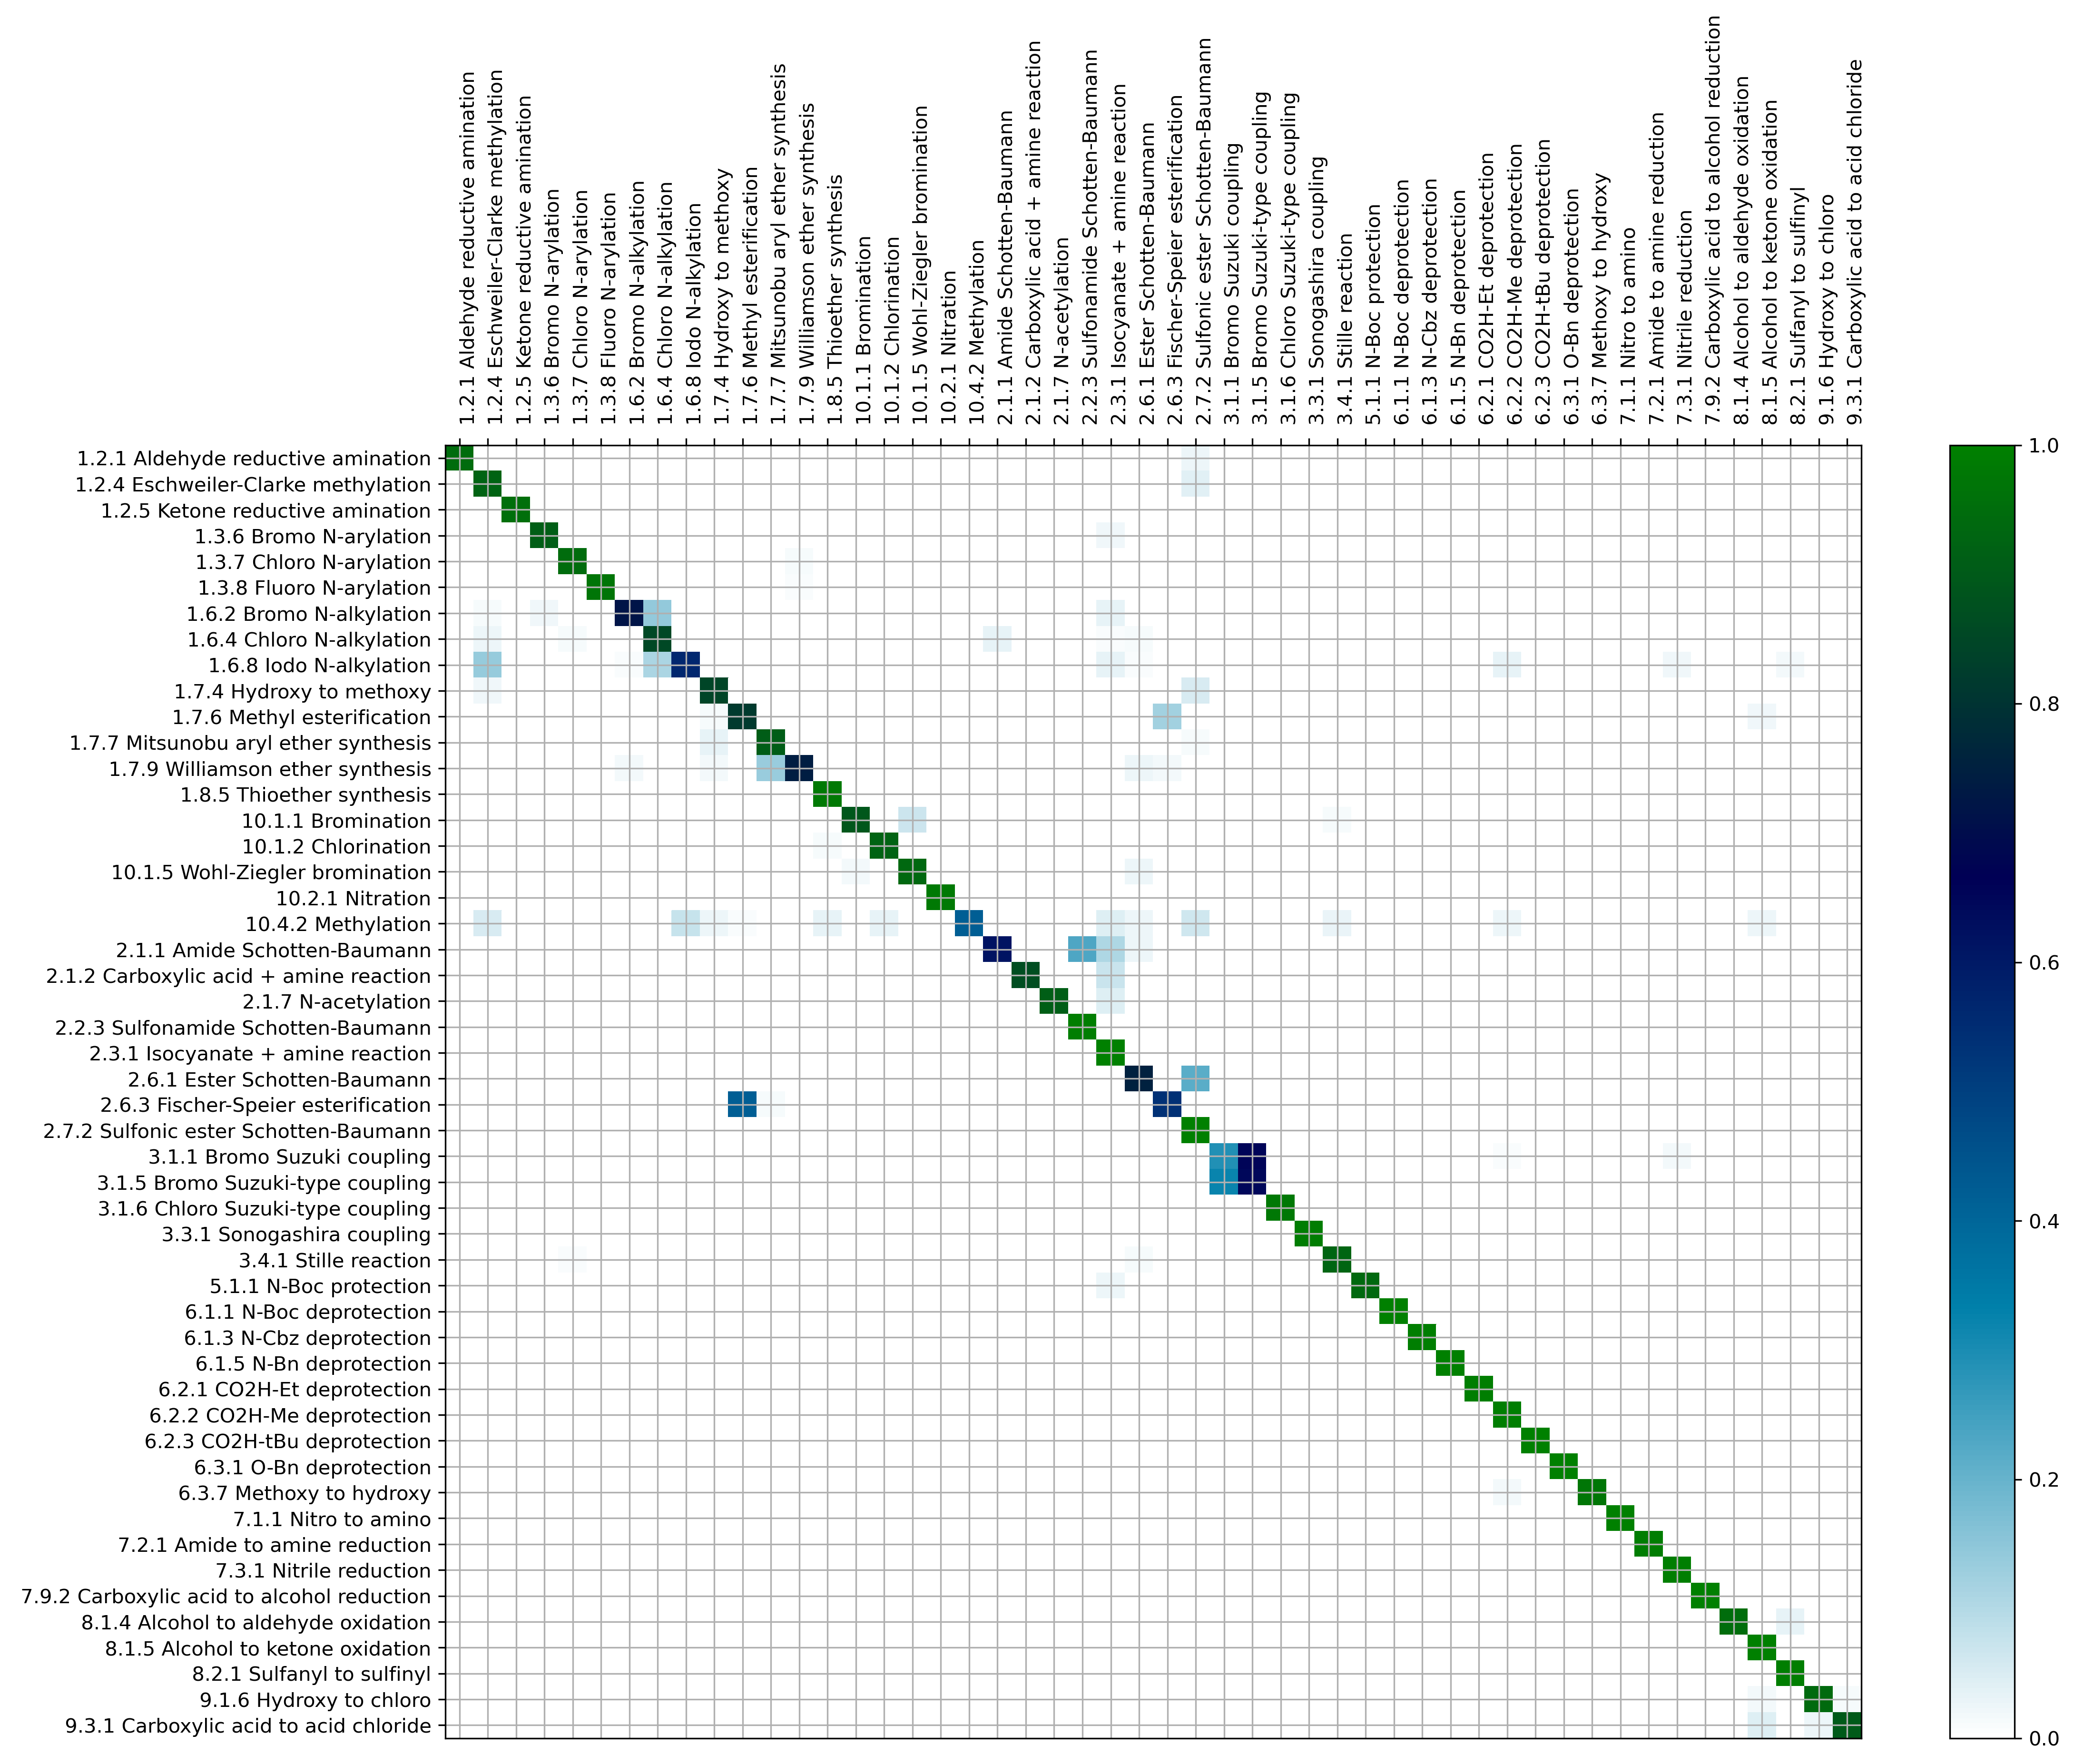

In [10]:
utilsFunctions.labelled_cmat(cmat_wA1,rtypes,figsize=(16,12), labelExtras=names_rTypes)

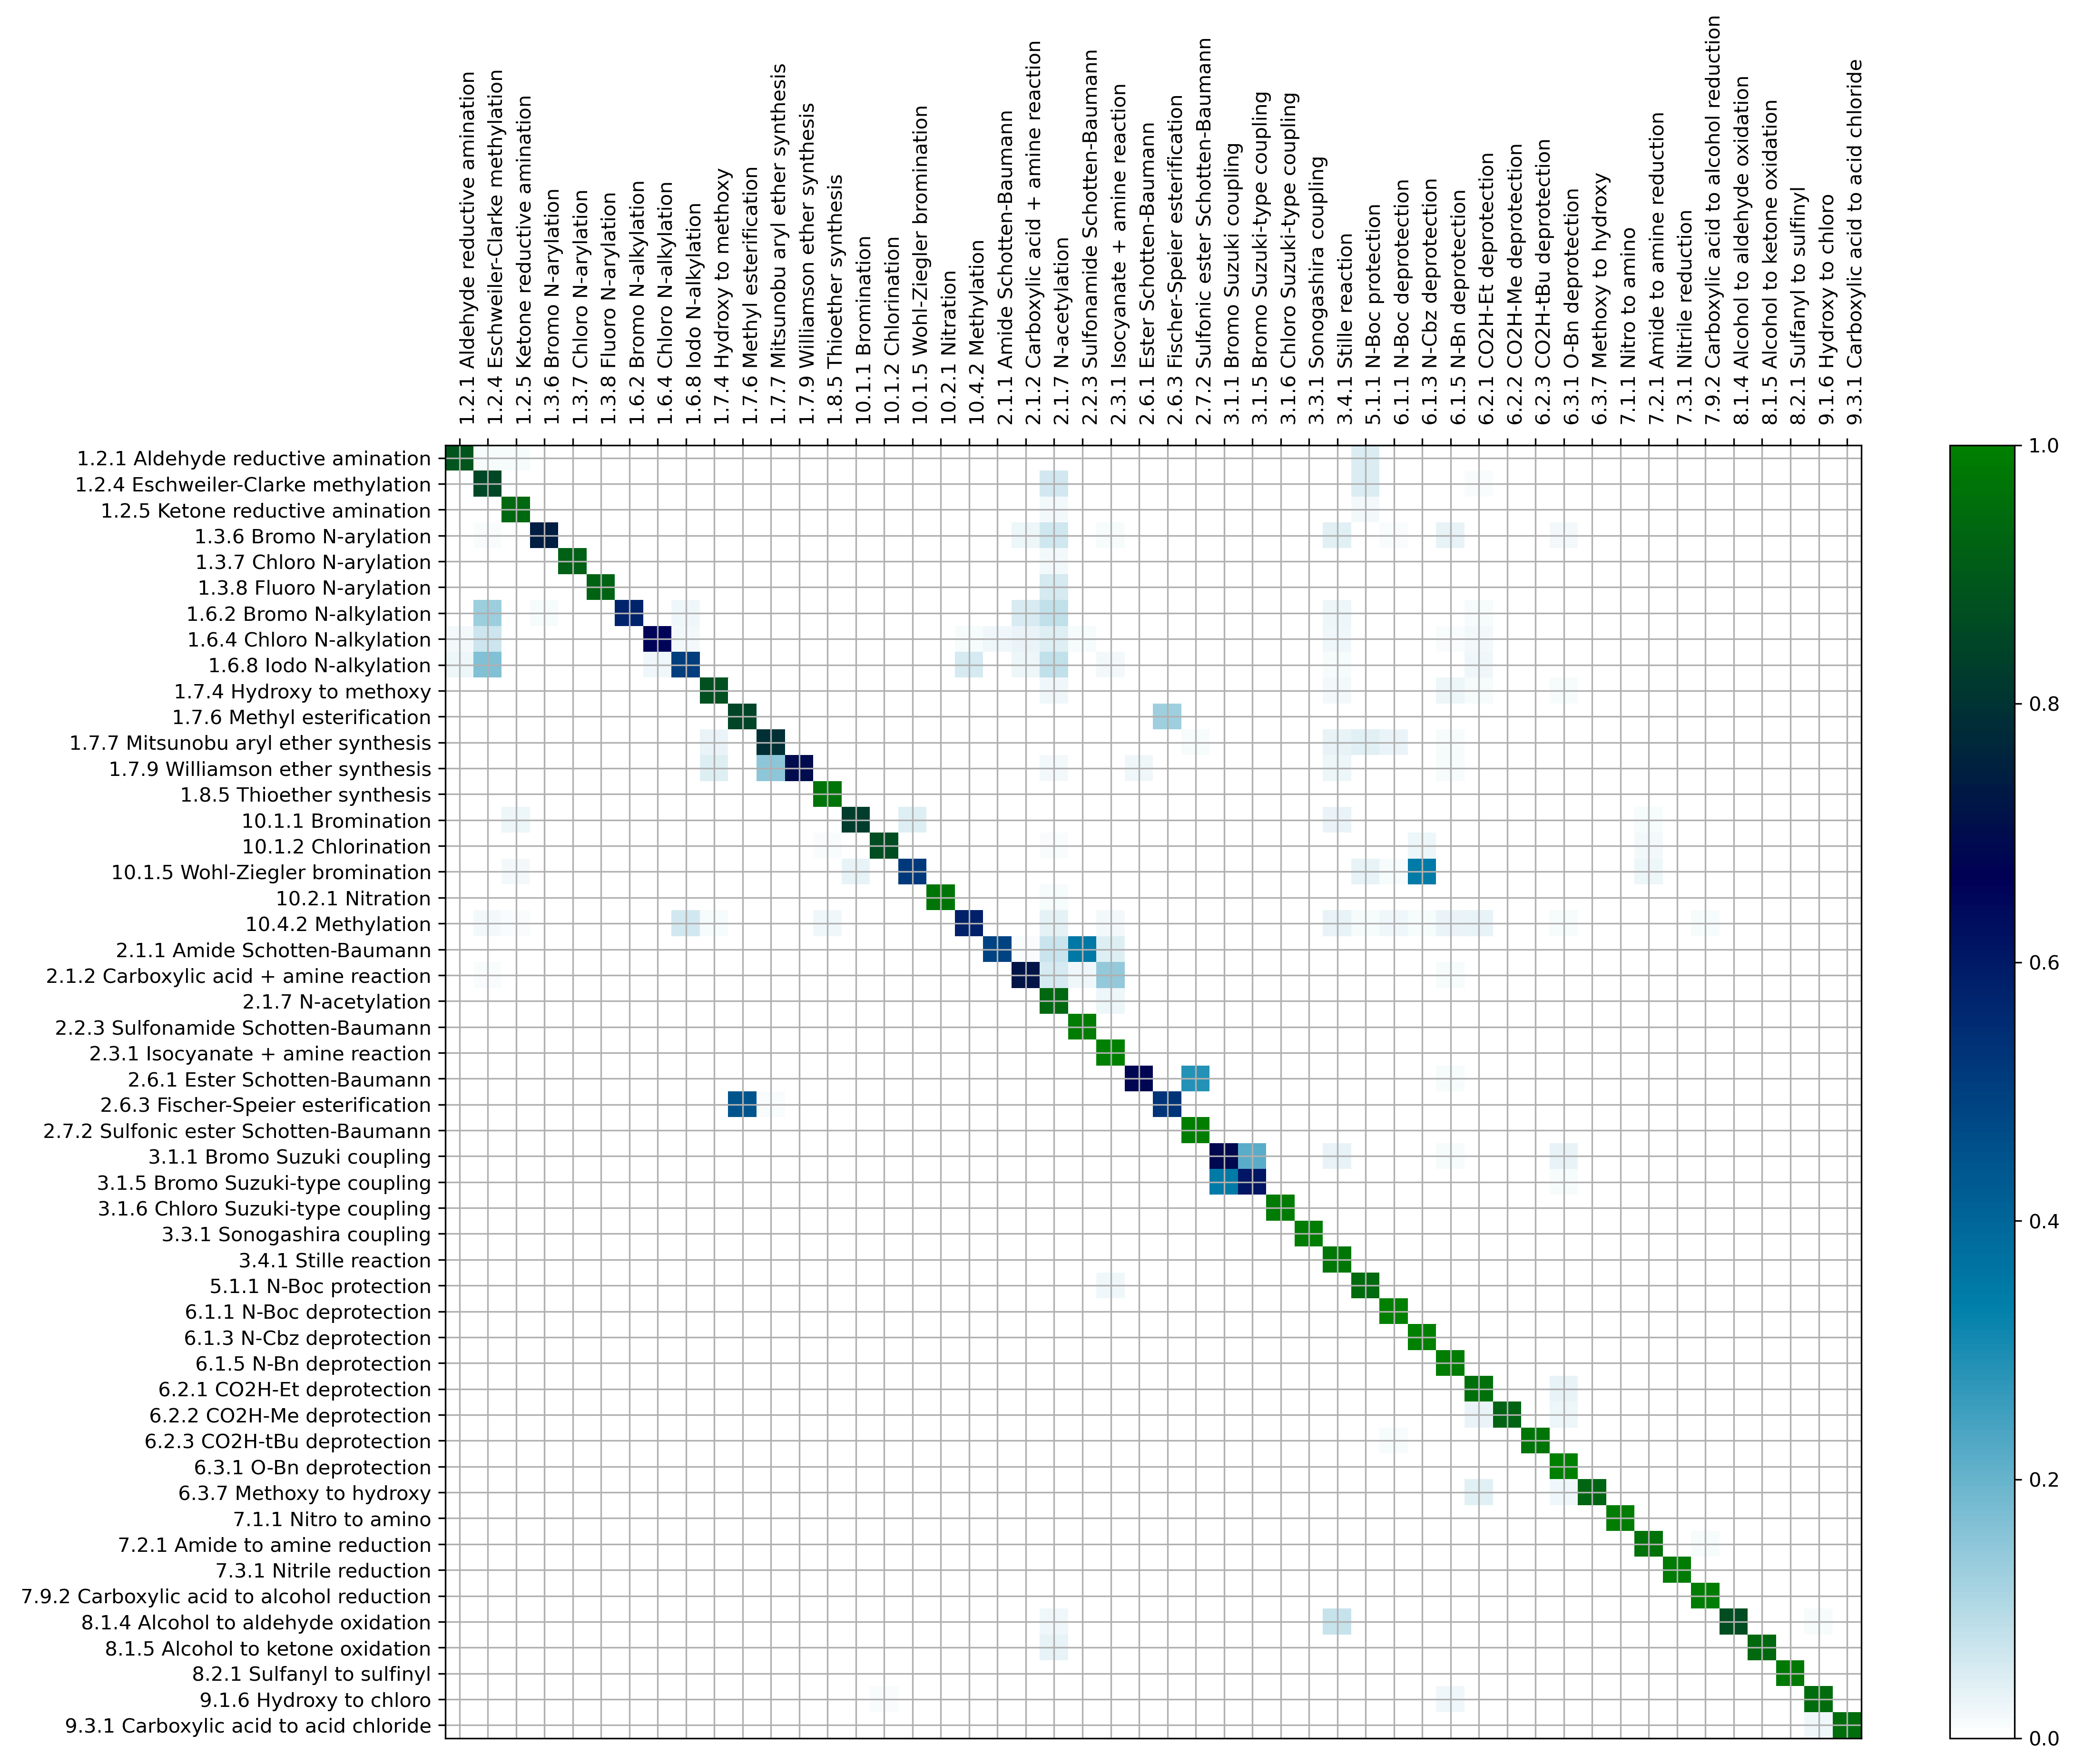

In [11]:
utilsFunctions.labelled_cmat(cmat_wA2,rtypes,figsize=(16,12),labelExtras=names_rTypes)

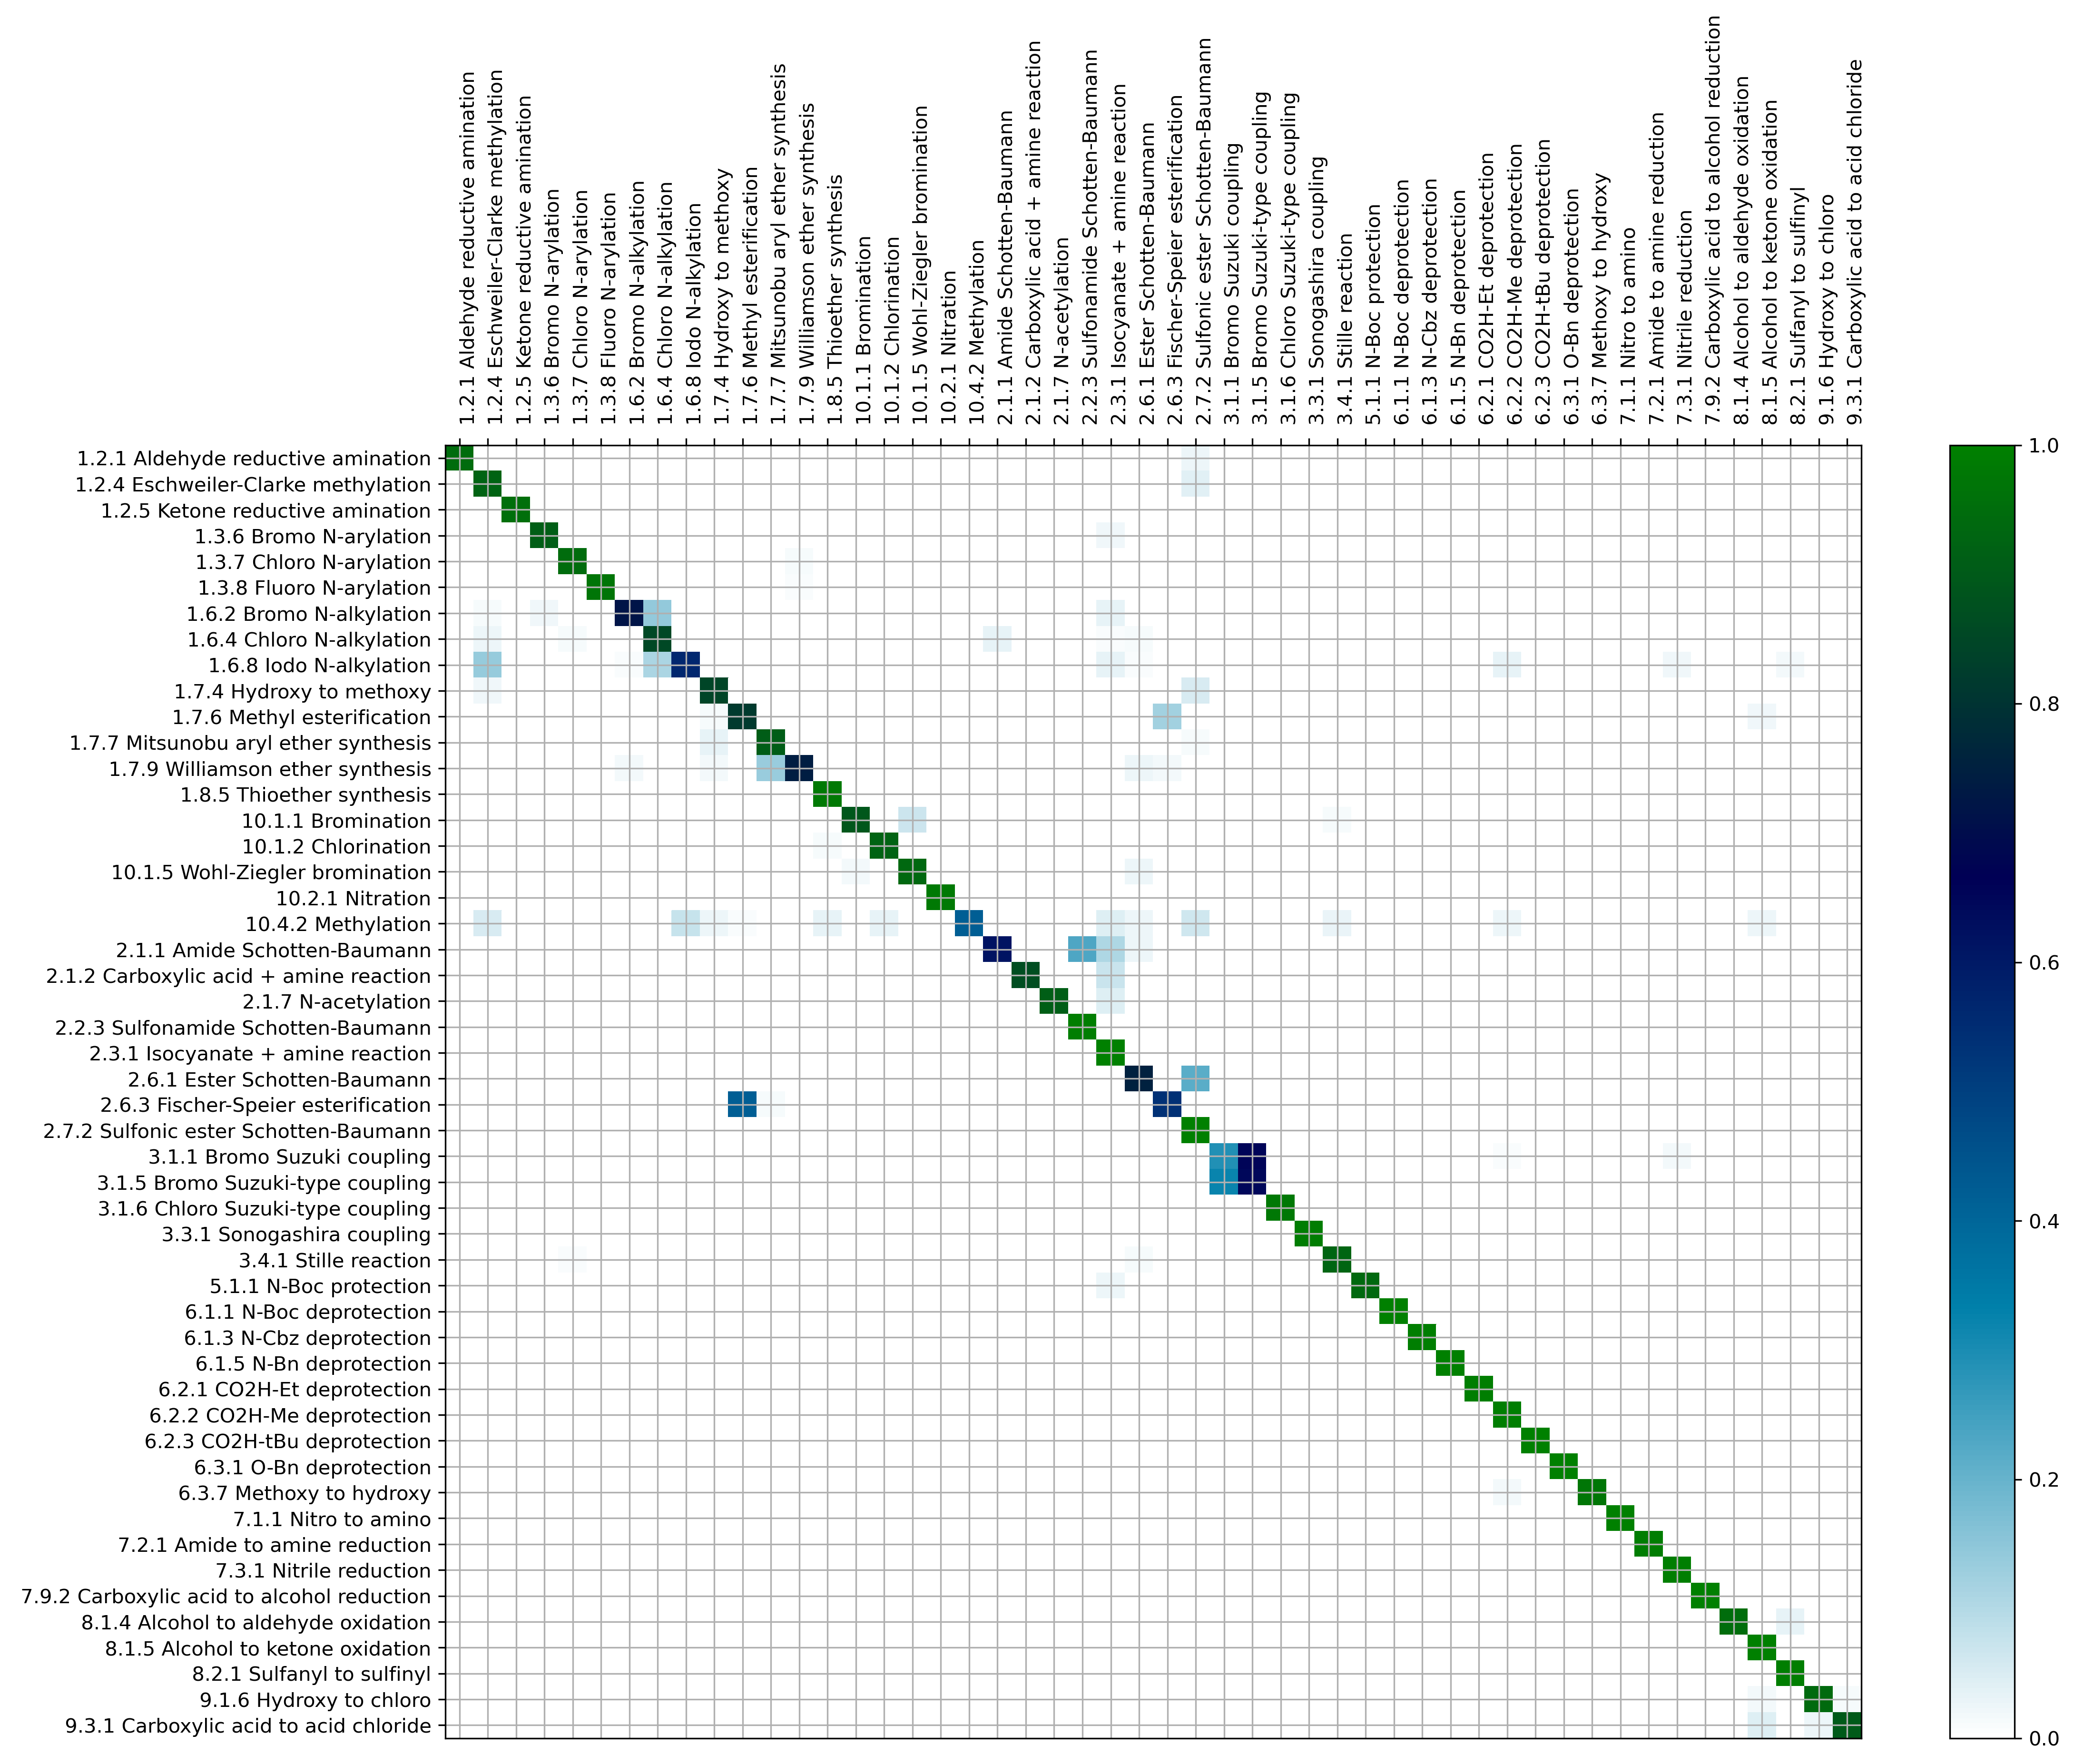

In [12]:
utilsFunctions.labelled_cmat(cmat_wA3,rtypes,figsize=(16,12),labelExtras=names_rTypes)

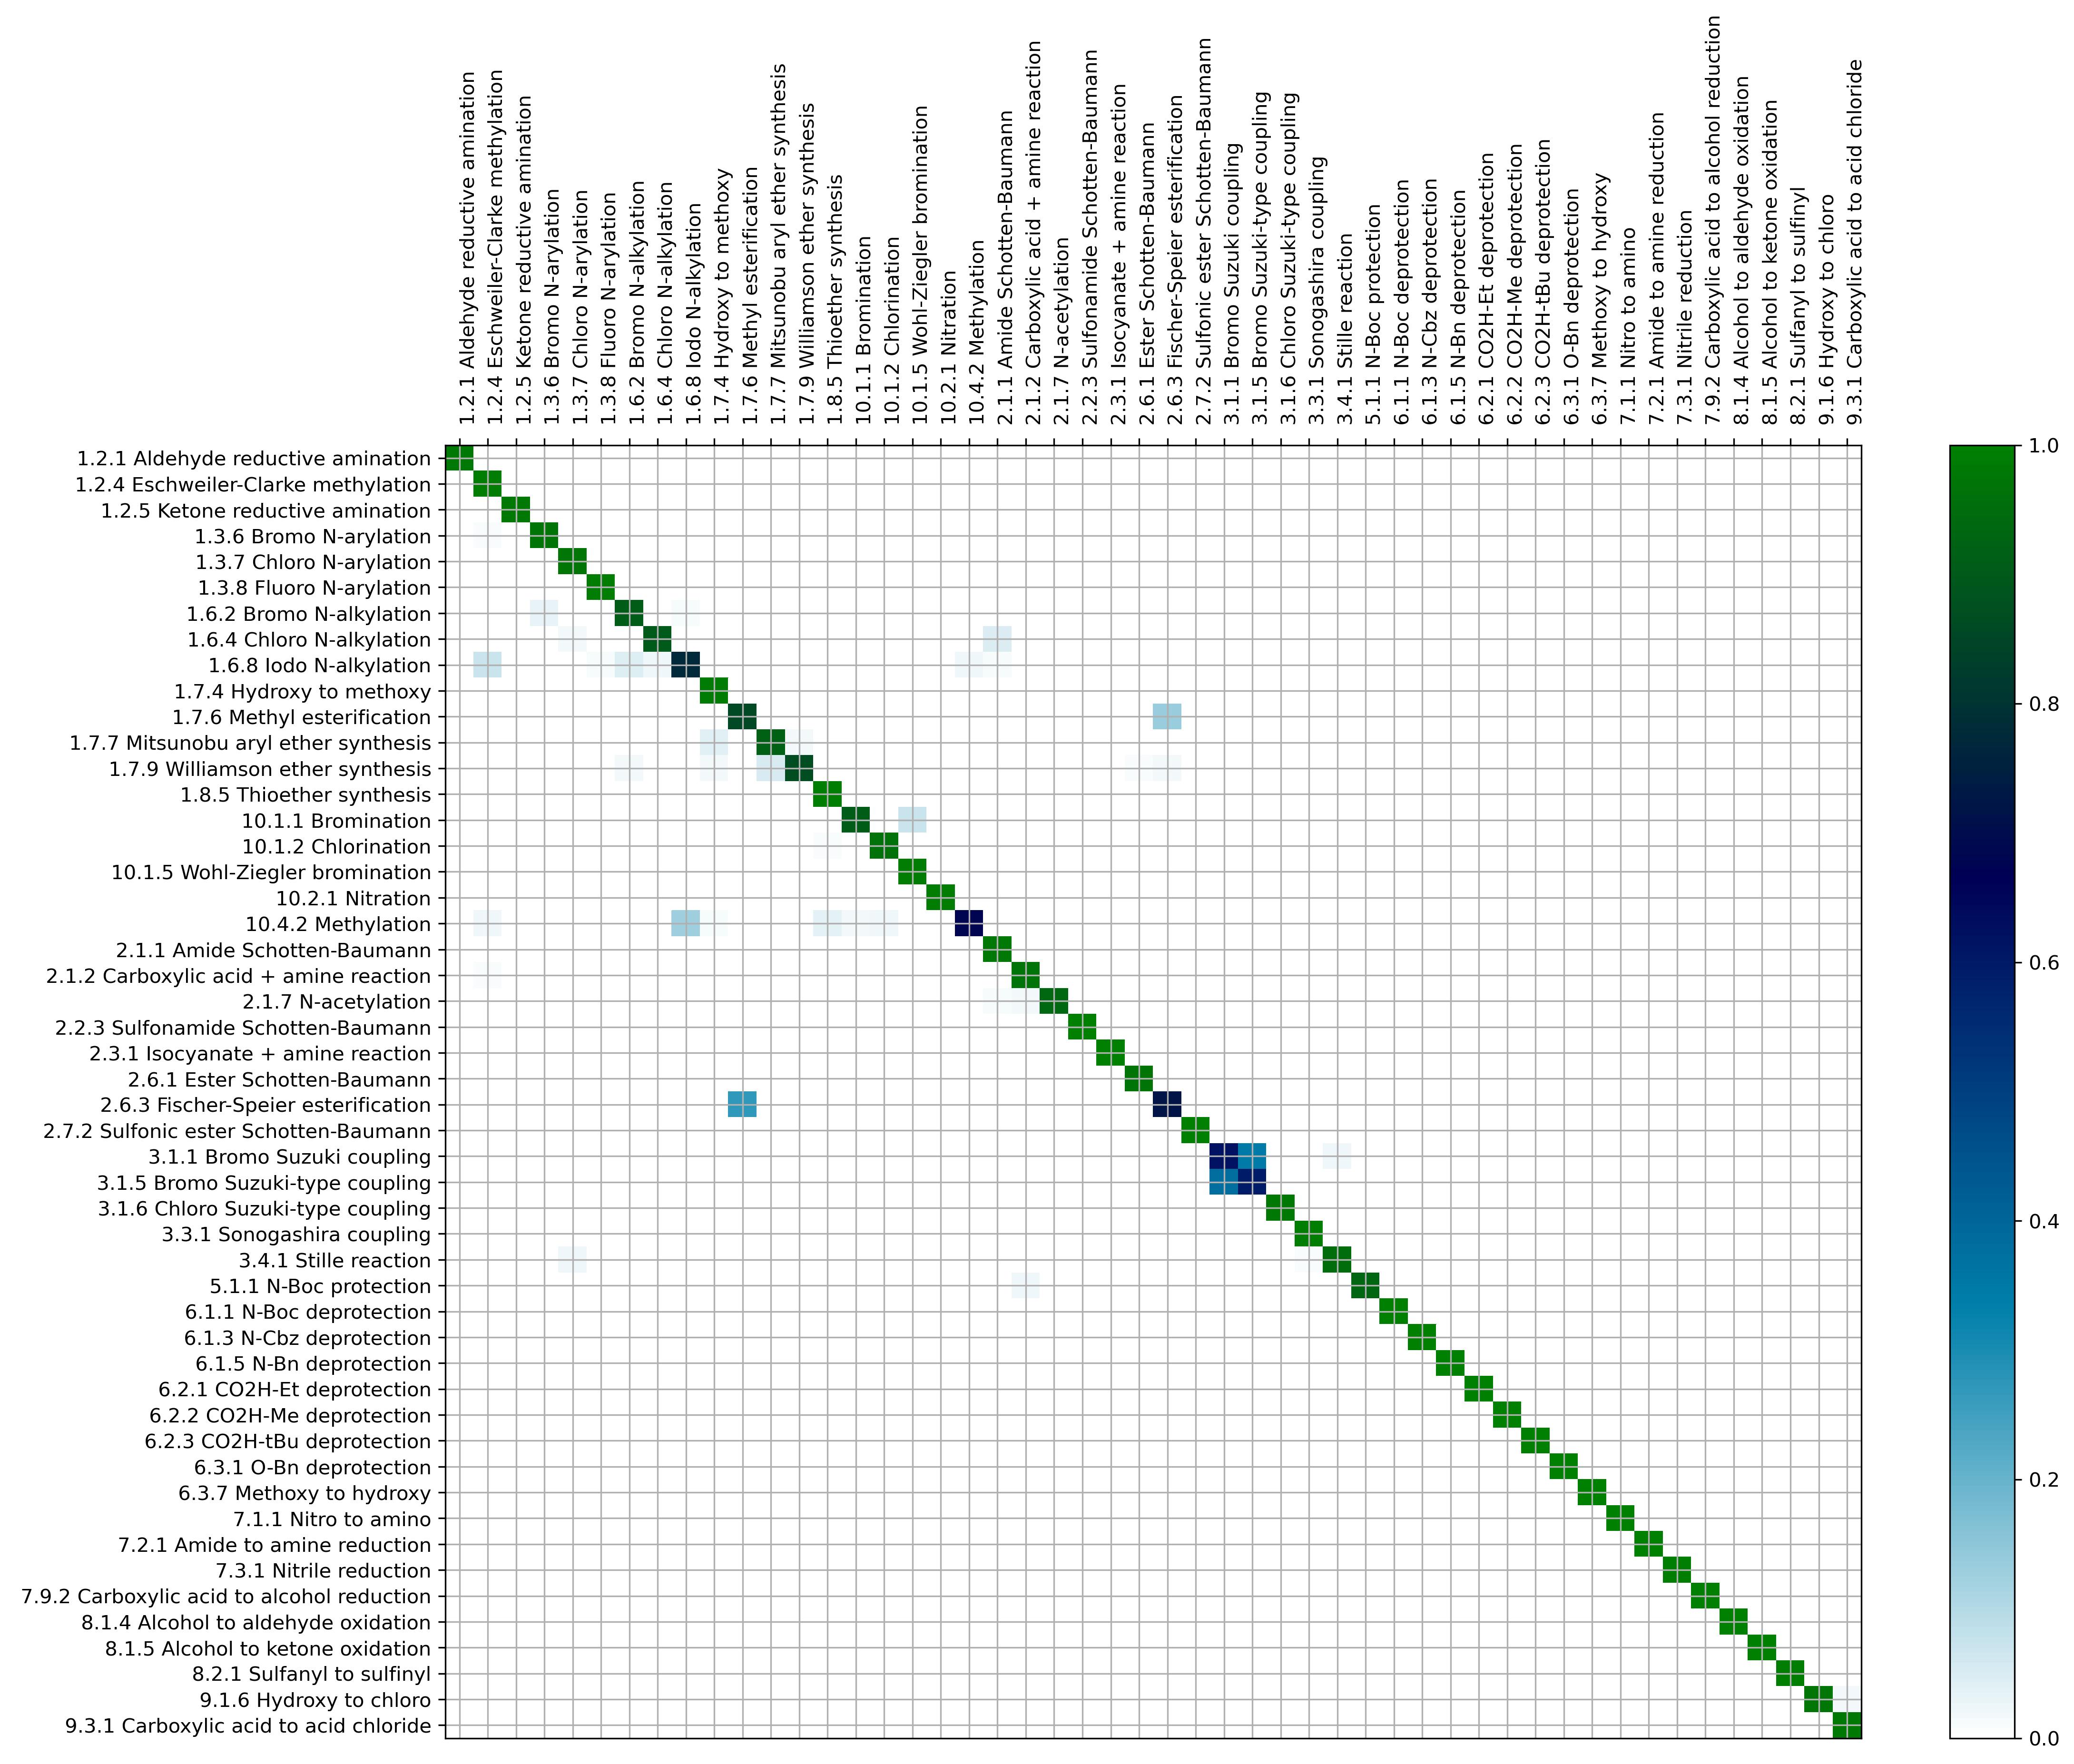

In [13]:
utilsFunctions.labelled_cmat(cmat_woA,rtypes,figsize=(16,12),labelExtras=names_rTypes)